In [12]:
import Pkg; Pkg.activate(pwd() * "/../../"); Pkg.instantiate();

  Activating environment at `/storage/work/s/suv87/julia/rdpg/Project.toml`


In [14]:
include("../networks.jl")

read_network (generic function with 1 method)

In [24]:
using Ripserer, PersistenceDiagrams, Plots

In [16]:
function generate_sbm(n, k, p, r)
    f = (x, y) -> r + p * (x == y)
    Z = rand(1:k, n)
    return generate_rdpg(f, Z)
end

generate_sbm (generic function with 1 method)

In [17]:
function diagram(X, dim_max; alpha=true)
    points = tuple.(eachcol(X)...)
    dgm = ripserer(Alpha(points), dim_max=dim_max)
    return dgm
end

function bottleneck_distances(X, Y, dim_max)
    DX = diagram(X, dim_max)
    DY = diagram(Y, dim_max)
    return [Bottleneck()(DX[d], DY[d]) for d in 1:dim_max+1]
end

bottleneck_distances (generic function with 1 method)

In [18]:
function slice(V, fun=mean; dim=1, i=1)
    if dim==1
        reshape( fun( V, dims=1 ), size(V, 3), size(V, 2), : )[i,:]
    elseif dim==2
        reshape( fun( V, dims=1 ), size(V, 3), size(V, 2), : )[:,i]
    end
end

slice (generic function with 2 methods)

In [19]:
function scale_embeddings(X)
    c = cov(X)
    U = eigvecs(c)
    s = U * Diagonal(eigvals(c) .^ -0.5) * transpose(U)
    return X * s
end

function simulate_one(A, d, epsilon, method)
    # Note: we add one to d, so don't add one yourself!
    X, _, _ = spectral_embeddings(A, d = d+1, scale = false)
    
    A_private = edge_flip(A, ϵ = epsilon)
    
    if method == :eps
        A_private = A_private .- privacy(ϵ = epsilon)
    end
    
    X_private, _, _ = spectral_embeddings(A_private, d = d+1, scale = false)
    
    if method == :eps
        X_private = X_private ./ (1 - 2 * privacy(ϵ = epsilon))
    elseif method == :noeps
        # X = scale_embeddings(X)
        # X_private = scale_embeddings(X_private)
        X = StatsBase.standardize(ZScoreTransform, X, dims=1)
        X_private = StatsBase.standardize(ZScoreTransform, X_private, dims=1)
    end
    
    # return maximum(bottleneck_distances(X, X_private, d+1))
    # why not record all dimensions and combine later?
    return bottleneck_distances(X, X_private, d)
end


simulate_one (generic function with 1 method)

In [21]:
p, r = 0.4, 0.1, 0.15
clust = 3
repeats = 10

N = [50, 100, 200, 400]
ϵ = [0.5, 1, 2, 4, 10]

In [22]:

n = length(N)
m = length(ϵ)

ne1 = zeros(repeats, n, m)
we1 = zeros(repeats, n, m)

ne2 = zeros(repeats, n, m)
we2 = zeros(repeats, n, m)

ne3 = zeros(repeats, n, m)
we3 = zeros(repeats, n, m)


for i in 1:n
    for j in 1:m
        for k in 1:repeats
            A = generate_sbm(N[i], clust, p, r)
            for method in [:eps, :noeps]
                results = simulate_one(A, 2, ϵ[j], method)
                fields = [n, ϵ, method]
                append!(fields, results)
                println(join(fields, "\t"))
                if method==:eps
                    we1[k, i, j] = results[1];
                    we2[k, i, j] = results[2];
                    we3[k, i, j] = results[3];
                else
                    ne1[k, i, j] = results[1];
                    ne2[k, i, j] = results[2];
                    ne3[k, i, j] = results[3];                
                end
            end
        end
    end
end

4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.5785839056756006	0.9879807906959392	0.08520795190647323


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4366812285285806	0.3211045762667686	0.11787781127795394
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.4978650268018985	0.60102273376589	0.18643227077553415
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4285438124308115	0.22048421267800955	0.06729832307171457
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.8600480788569236	0.7513518214011174	0.0973560915652052


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5355828099582789	0.19616008887639147	0.0796140103324714
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	2.007639261244413	0.4922807811183332	0.06578058704141587
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.47470951165528086	0.2327156009252691	0.1399434892886906
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.5274085950484555	0.6675109424445447	0.36361589824962026
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.29233901077319446	0.23412629717474798	0.05542552693493508


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.1736718011427567	0.767380675321687	0.10052220121362732
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.7730565740065634	0.23197616881987182	0.051380262643334396
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.5752048121462798	0.7253504937214021	0.11377723851907495
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4378707579212324	0.19745565366748719	0.10596463672481171
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.7177722727059224	0.7503600486735076	0.11394302530107359


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.527784173624537	0.27600562897116476	0.15480392623323125
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.7139767243243778	0.7700099016728936	0.11209448921729859
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.2823320330685226	0.21939866273756548	0.24758669125546962
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.3838739924912709	0.6516673165709053	0.13787197046349497
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.308384312482624	0.24988202639940948	0.03276297133297579


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.48567899882343335	0.4221312805578574	0.1324147891815055
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.24541965057233317	0.26090343197857613	0.08307655625225352
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.5583556609174073	0.2718467368313634	0.018005153519190187
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.23224603412700884	0.38410443956118767	0.12599932470084618
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.5314472062517118	0.37153507373258177	0.028145001117925617


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.2371566217605367	0.22689348168694168	0.08462270586510123
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.4979586252091246	0.3786395490764626	0.07928781970278931
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6267413333023508	0.23931428223671336	0.10654382865823919
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.8099997572324333	0.4444382806829198	0.13287467786857254
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.49558687611227725	0.5194885873241795	0.1341093800536639


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.44468721170126757	0.40254929405451256	0.07975540640483048
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6099196815431097	0.42249881451455296	0.0870430691043631
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.49982385582752903	0.22287682601239167	0.016240904240746423
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.33259079284363446	0.4551233580120613	0.19384102930245173
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.5173840808033645	0.441343187958786	0.04182582624304909


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.12412712519790747	0.34948828260182463	0.10816844736235254
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.5805553189928745	0.28894785490322894	0.028146530336436548
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6284823579144929	0.20893391272960582	0.0468156942503517
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.5665748096208771	0.2820428215074827	0.03617426146356073
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.28238494382688106	0.2179505541604254	0.05946527049599659


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.17180518967470143	0.07759354522551792	0.05248033267747554
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.24590124912399403	0.2596694854878536	0.041662693185477884
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.19907690389162425	0.11464931105715581	0.007649622363451236
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.320559219869887	0.20542336851308796	0.059262536368634544
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.24358145655529956	0.13848459041735595	0.021467316797190272


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4731305043944045	0.4271893380277916	0.0765220070168704
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.18422499313839014	0.16456008888704848	0.027505713111887653
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.303278985562192	0.2566027494758316	0.1268563456875802
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.16699338215246595	0.1317545034504931	0.020416973163247087
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.2293721586837234	0.19684513766759015	0.08760441274037545


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.16714295871139917	0.22585343465272456	0.01706843192316071
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.17704106961301624	0.13900167256988594	0.03912281323003741
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.22654430356827487	0.15288498962397745	0.019017258215138222
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.3553798550709477	0.241829839879107	0.09928004525235079
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.24847980566943412	0.09168684611160072	0.025380667037015026


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.37801883715267015	0.22574294959377383	0.1366311155755051
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.16025980959044836	0.09157406663785672	0.02076494836885956
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.47735371726938813	0.16361929427979716	0.03622264434932054
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.1811192940885537	0.17486719174208598	0.02449970606665175
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.33277017529678876	0.20701064619045417	0.07258178869680298


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.08651497180595591	0.04540172002870918	0.006605709763989942
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.3213036756483303	0.20007279159004454	0.029761196288219827
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.0940772245448333	0.03022122964053653	0.011226709167156845
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.24647246976379866	0.21895362437180088	0.049275725317332375
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.14086909551987226	0.05048442228925093	0.014183695458917067
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.21989564935372952	0.17710177157140783	0.021760123809980048


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.048239555656990396	0.06743427067329882	0.008562138403685637
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5943129073431674	0.29217498701137723	0.06294888860651016
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.041488629339701544	0.04299134301350879	0.005878999290855225
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.3954264422559227	0.2676609682320006	0.06076381158418265
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.233721632845994	0.15351319282532339	0.007863355382274007


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.3737829296972266	0.3172523321958407	0.10157628575310129
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.14484633626754578	0.06584550581573662	0.01648834593009013
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.16896641651386668	0.2569892543999801	0.025305264245292003
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.0675358401401166	0.07459769091051316	0.020372424686710078
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.13702324793199339	0.1652782181524699	0.06115194311346661


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.058620458409764487	0.0691131254658024	0.0039999810487890974
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.12505528387983866	0.1589750338367446	0.14447061183206245
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.07957774544065224	0.062473381621173774	0.003474337639767122
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.24744217837482618	0.26909706933941147	0.04684055949541266
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.291056077804223e-5	8.946844649138086e-5	7.989767800159475e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	7.327471962526033e-15	1.021405182655144e-14	8.881784197001252e-15


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	5.003912797829635e-5	4.7009162640054836e-5	4.3777060465211015e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.0637286041140318	0.04884352473244491	0.02594479195699373
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	3.75023274504227e-5	6.147530009970037e-5	5.136789240400841e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	7.827072323607354e-15	1.1324274851176597e-14	4.107825191113079e-15
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	3.754684920148632e-5	6.729838927660436e-5	5.64495855289171e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	5.828670879282072e-15	6.5503158452884236e-15	5.329070518200751e-15


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.524443897124808e-5	6.471893511972304e-5	7.003107126835051e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	8.881784197001252e-15	7.105427357601002e-15	3.4416913763379853e-15
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.5886246454185375e-5	5.588719396509845e-5	5.5838558860155096e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	6.439293542825908e-15	5.662137425588298e-15	6.5503158452884236e-15
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	5.5340647985874236e-5	7.06610514101258e-5	6.546350046687799e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	1.7763568394002505e-14	1.5432100042289676e-14	1.2656542480726785e-14


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.172789371462149e-5	7.823956961022782e-5	7.1620518765525e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	3.552713678800501e-15	4.884981308350689e-15	4.884981308350689e-15
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.8915084086276206e-5	5.946452095734189e-5	5.890441910594291e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	4.218847493575595e-15	8.215650382226158e-15	3.6637359812630166e-15
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	3.588026194190075e-5	7.503000984565578e-5	5.460136679247274e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	9.603429163007604e-15	9.547918011776346e-15	7.438494264988549e-15


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.4920285906563377	0.4597399301591716	0.10118093704403996
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6439208123407525	0.30975447792251654	0.1309393849281173


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.0318987388168017	0.5240539742438863	0.12911318834566665
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6487808691027628	0.42224980246381905	0.16218851315077254


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.3945399666901581	0.6261685214070607	0.12611614714715946
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6945211318896036	0.3474609754351612	0.14384221250967655


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.5327593228674576	0.5254068013749061	0.2180011625935423
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4037707205952642	0.2921147198587809	0.0690135722421581


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.0555813061598354	0.604819482674102	0.16542428064670434
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4118765760496583	0.39691503198738753	0.13789262007749215


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.2633078718837574	0.7647726145172866	0.12951623495132414


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4413218205553085	0.2968751659592924	0.16071829568788254
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.372763977396873	0.42823563557286914	0.12004794041143141


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5779685834214626	0.3515086431061458	0.21159951958150058
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.4044717767169685	0.38708342711128574	0.09242581972946584


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5194416249124968	0.2638221951479154	0.14898926801004997
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.2929962877352101	0.6180156860307584	0.1577565607168092


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.37380195087476825	0.4254058223308892	0.1585056102071618
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.394670330905819	0.5206366652738498	0.07397384954441333


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.669336018141857	0.6791318951310427	0.18461283906531767
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.5713871990967991	0.21875702080581727	0.04098699376276094


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.28981273066017976	0.1593327824658859	0.07330206400211337
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.46139588329194714	0.2814915379109171	0.07564124079941181


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.512954566254384	0.4229714873688599	0.1227734446467279
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.41017448911817567	0.19149999450055855	0.07755003504819113


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4475255532205439	0.34537124442059786	0.15632413219949481
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.4849757152385761	0.21236657225177014	0.11720297898456378


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.453436054857859	0.34192934619297977	0.0566598314821094
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.38180695437338596	0.21995334231080033	0.034521207644442664


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.504601263722521	0.3108642161241475	0.07192638678780594
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.3559527440019541	0.21836723961275284	0.0930451012041309


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.3486449144890147	0.3097450916509642	0.1482670030992841


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.3692473465987321	0.13362336616528248	0.078312704766479
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4410654696835249	0.3269908617853703	0.10418358584625753


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.537044301327526	0.24471411531604959	0.07284326085902759
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.41758294175705635	0.26587099799330494	0.18277718762928363


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.40535312597421513	0.12780266250497996	0.08162945123306209
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.7697481300840303	0.41108669576107515	0.09713647411452975


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.35761175100323	0.18976740487429572	0.04674279208516785
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.44232803639642837	0.26393419398215046	0.22864646776267294


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.13062385140831062	0.11393871447061077	0.018165862879766903
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.47304023167495846	0.3596679534402132	0.08076736040151777


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.15100879205290407	0.09735733229637167	0.014177517561096808
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.28007080096285	0.3669845546761268	0.032264635730193


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.117235703588006	0.1017470491735028	0.023259075436762033
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.3029446498721958	0.3669729206054173	0.13429208070395027


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.1389694220496738	0.1599571681845529	0.02317049927605158
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4588620489578661	0.5048954782060606	0.1318122674190383


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.14451524430360682	0.12458811767973832	0.01081707333510562
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.19921135482743835	0.3118857876388965	0.08009424612117066


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.09745824539644654	0.13148289706690097	0.032975939578232416
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.40041643054412057	0.15459131611591126	0.13520630787401955


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.13672255415861714	0.09474001105558288	0.010116465238574845
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.2500792512890783	0.2695814233191204	0.12983318987364423


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.11516004652864142	0.11974752413232886	0.011109856721532613
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.3377267421973337	0.36977737943565714	0.16785240336212048


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.1264937197124953	0.1421012606467817	0.014817492190903614
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4705311868758286	0.1683952706001295	0.10704821783620577


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.1462647898858121	0.0678794484010038	0.030691092183369406
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.3502163212080228	0.35707985092934547	0.0713981424727268


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.04381241473460776	0.049852512530102144	0.015363657550216875
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.17233412695728123	0.19733874922526018	0.044752551561110465


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.023459054859179818	0.027534662434786	0.01064926324093654
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4866802134948417	0.18987961877390935	0.02114963530065672


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.052344224848809184	0.04700393458282648	0.008752053140936827
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.301019490637519	0.2052852552962119	0.039714381339671534


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.06236483473209742	0.07294668436883667	0.007021837630395156
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.10566642150801409	0.10166993067413244	0.07937301029513644


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.03880171515343106	0.023810111247843407	0.013150903435789618
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.27146375651934385	0.14241785938266815	0.07458034683586368


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.06345670904724954	0.07002062514781648	0.007977642812618785
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.23179707997180965	0.12031037128940314	0.049752170560739106


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.04149965968913505	0.045062701463444044	0.0032696891119068927
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.426243359416032	0.22288457878390733	0.08753660729423673


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.03125727080032825	0.027142894546261898	0.008556522605687733
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.190262586950098	0.1877206314947284	0.1747344272912672


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.016826920883122154	0.05721350503204309	0.0042218936819034825
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.19557921036168802	0.18766856157955214	0.07289482096446598


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.03978015636632842	0.05180274564090903	0.012371389542301714
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.2823372667474042	0.26519584821308584	0.030002139970985553


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	3.61072303787513e-5	5.79776350971839e-5	4.215485899167204e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	7.882583474838611e-15	1.0880185641326534e-14	7.716050021144838e-15


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.009355263711935825	0.00969259093626354	0.002945354606015055
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	6.827871601444713e-15	6.5503158452884236e-15	6.994405055138486e-15
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	3.2483332509769536e-5	4.755448985033217e-5	2.8065317720787908e-5


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	5.551115123125783e-15	6.994405055138486e-15	4.052314039881821e-15
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.335011498490804e-5	5.062631913799187e-5	2.1983839629119428e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	8.215650382226158e-15	1.1907141939104804e-14	4.551914400963142e-15


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.173251662825672e-5	5.7011809981855066e-5	2.7084190391740703e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	7.771561172376096e-15	8.215650382226158e-15	6.439293542825908e-15
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.304961161383236e-5	6.129660162568218e-5	2.6808441131453975e-5


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.02165262038415572	0.03208273773598297	0.012039933327478824
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	3.676357056925372e-5	5.30417421876761e-5	5.2117826319197924e-5


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	6.2727600891321345e-15	5.828670879282072e-15	5.10702591327572e-15
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.843222746686582e-5	6.300598130015711e-5	5.1786720839053224e-5


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	1.2712053631958042e-14	2.0761170560490427e-14	7.993605777301127e-15
4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.5861786799827886e-5	5.9066715632494216e-5	3.964521653859743e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.021839568351387305	0.0214603111748779	0.02069445122319924


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.439123413307877e-5	5.6164758302168494e-5	6.095857558163775e-5
4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	4.9404924595819466e-15	1.0602629885170245e-14	4.9960036108132044e-15


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.1256828419341316	0.3455557221446873	0.14286265005749088


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5815392871985834	0.4081950349317287	0.27149512862739256


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.9976935800892112	0.3971341964848403	0.15415782735356687


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.7424986833226475	0.2586247097825193	0.26930003222921317


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.1760129152251162	0.49868123584853163	0.15477385618697836


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4544833830878781	0.2880609723076699	0.18360344123416827


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.9763900279894966	0.4091261047433039	0.12148050503310781


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5310992681271629	0.3924402919796022	0.17887556655155112


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	1.1589686810535869	0.49123323614838477	0.12907078699266572


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6265429451432474	0.38564170016639776	0.12981741942204983


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.8001489946901931	0.3868862053804213	0.25059823154153604


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.9457807948760016	0.3757776438864707	0.14491341898485088


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.9810674228970654	0.37237882137911194	0.12706745256717344


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.43714528990563606	0.39821724136930015	0.2684133511040332


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.9531911280857458	0.3803163116156927	0.16090845383879404


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5066601710654731	0.3842412299356148	0.3412516573724964


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.8401479910792914	0.3490084177538292	0.22847767727128565


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6037676104974337	0.33395795463603783	0.16783935953957574


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.8121913461277019	0.3745015928068016	0.08794435167362846


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6966683826053376	0.4236762392464166	0.14836301295350451


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.2971672626002142	0.15801895656582937	0.05471367242253705


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4513477352180835	0.2723364922757461	0.10499480140099382


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.26425951078083765	0.1894123904418311	0.04758988491838645


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.44490996155531704	0.39297311829763093	0.11381956236493451


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.2549338362209489	0.15873763862917145	0.09384333240300302


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6921411188935591	0.4239722035067792	0.28864778299913096


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.2978615900073332	0.15928680072965373	0.0388212901174142


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5189461597016879	0.43338300219692183	0.1494158840009765


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.2802188190399282	0.24133538595863102	0.10879593661435683


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6546572547758029	0.3064466880628175	0.1287175062371153


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.33954341980383274	0.1623974534209633	0.04549104962463557


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.3657379293649773	0.4303646862624583	0.13490554160443802


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.29836320359463225	0.17382166312487524	0.09039541544536511


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4118201343779471	0.3367557711744773	0.209830598686519


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.33852992086933803	0.1998592793747419	0.03949272421056205


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5998180534385648	0.4269608664092108	0.07536168666905962


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.352549197547945	0.21496120854343065	0.036070615335925205


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.8012049467667681	0.4139804673786255	0.15492977195165492


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.2678473572874732	0.1651982658279379	0.05030673651827078


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.36666831584553267	0.38367834651027943	0.16001376590050098


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.1406520790373804	0.041532877144113745	0.01585430730814677


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4234853277638926	0.24872572651033487	0.1090612034367997


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.21707023231914857	0.06266316602231659	0.04144603194186905


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.48753004352388796	0.3712715496477612	0.2479553217280801


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.15736940582306158	0.12495398062258495	0.022488042280954024


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5753203896085494	0.17566379927751674	0.03682309038277776


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.14917520187521532	0.1200183844059961	0.012101023804255623


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.544366459198034	0.5078590360192592	0.04662054709929486


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.17043831330511078	0.07301639604227506	0.014030407958879942


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.436261190525459	0.31298914593610916	0.09030663601545386


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.18724029093209937	0.16252127069033478	0.013956391859040851


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4970850490988492	0.4130091263591651	0.09414762808497379


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.1794311648600953	0.050315835279335114	0.02419277691537297


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6782506116591572	0.3876471315864658	0.08338437753628836


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.14724399550178985	0.08283822839393251	0.0225925757599455


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5471060672451649	0.2350893449309126	0.03947573307394214


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.1514073478125021	0.0635830960244175	0.022316484995530295


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4595883681443902	0.34686602459281235	0.07822581419201446


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.09911757355858572	0.0704781623352525	0.013154673356664925


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5730351781054578	0.28787443632309806	0.050803906156634104


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.07899947414346253	0.022520497980096976	0.005476818346664622


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.14834364874395067	0.12973903170012524	0.03075438799160013


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.0644045726830057	0.009750217435543829	0.00502336036021811


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.14805475405199225	0.08224489572033744	0.031042785526232075


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.06289395074691984	0.023805825886679566	0.006604084557063225


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.2927707461850164	0.11536133303112539	0.08222267487774282


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.06133638532398111	0.027451671472315864	0.004319084282444485


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.2233877806777962	0.12474962811878432	0.022539665466953962


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.02950863151025107	0.01896416408232171	0.005035579967465939


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.16112186075056467	0.10515712008959266	0.030958382199667622


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.022389834790298047	0.023316877868817865	0.004703533136787369


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.1913240696052423	0.13902334105830705	0.040307951363968364


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.07507860486880208	0.04283086549327142	0.005230826712270556


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.313993653060908	0.1186283664880623	0.04578263867434007


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.051190210059187946	0.0651760359913498	0.005066938012636982


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.14489989540286918	0.10499744510472442	0.05090764973488815


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.031301142623779254	0.040122046125901645	0.008783713526307538


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.1307861900559406	0.09703565580352058	0.08687489935396941


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.045410271247384476	0.06848955118559308	0.007454701760448573


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.19125288847512112	0.11923289273180315	0.0435747209689481


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.001433663343578695	0.004843783832694244	0.0008832596994207131


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.05957367957594295	0.04323244699063278	0.004897200912799327


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.557090618184656e-5	5.999331205597258e-5	2.430151040444528e-5


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.005267013018057612	0.009290696991432423	0.002427589320088408


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.991469653226055e-5	6.251745837837497e-5	2.0574119501376442e-5


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.01451003516147159	0.036401033875808064	0.009616749122864643


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.0009293189200152117	0.0012713342331599486	0.0007466250351675016


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	1.787459069646502e-14	1.8346435481930712e-14	8.132383655379272e-15


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.003665271798916292	0.0078023703387624654	0.0021687223523086246


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	9.18709552877317e-15	1.2212453270876722e-14	9.131584377541913e-15


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.002424868678382777	0.0058310503409344655	0.0037557016555699735


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	1.6014967130217883e-14	2.4730217873525362e-14	1.2823075934420558e-14


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.196270473399988e-5	5.179752627859635e-5	1.642300032690669e-5


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.009410970527064938	0.02447468531254743	0.011538356395730781


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.88104383481458e-5	5.824490469730215e-5	2.434121225305952e-5


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.013223913602391182	0.016487821212606724	0.0034664972922249793


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.3217507864956595e-5	5.666338727983167e-5	5.880815379555315e-5


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	1.4710455076283324e-14	1.662558979376172e-14	1.1213252548714081e-14


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	4.554177108795354e-5	6.17950396578637e-5	6.184152511001795e-5


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	1.837419105754634e-14	1.8318679906315083e-14	1.759703494030873e-14


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.7782917302306062	0.22589016615401325	0.13915091462282525


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.7134192346951413	0.41810592050901707	0.26427155835413296


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.5893830185872988	0.25215093822090956	0.10941361619960366


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.8384469493210026	0.4691560467042072	0.2219794487729142


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.7827362749135166	0.28847175181549245	0.12990936503963768


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6304474450045634	0.353657038212593	0.2448235520645985


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.5874986000891024	0.24192671719359643	0.16782075324994217


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5680489037171907	0.32037344210680696	0.18268263801512985


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.7831248975849818	0.2601635407162352	0.17209748020069182


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6529000088089421	0.3090784083534497	0.2659386256775076


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.761550832343068	0.25175125069782955	0.09213447865757518


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5864022862407225	0.42732407907724057	0.21783529456174555


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.7380578827241397	0.2922807092483076	0.1802794407169389


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6661417553219207	0.4538990078123606	0.258274273372301


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.6884021195431114	0.2315192901153399	0.14990228056467747


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5457849810685633	0.45046409474203797	0.16776844034508454


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.8004252203945235	0.2922132857725163	0.11196152960962691


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.7034624815097462	0.4901960037464109	0.12749433523634512


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.6295755743353328	0.28719971810573613	0.12957786295521456


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.794063461394193	0.29267852251715243	0.2018658295714748


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.2893657929384264	0.24061051758101054	0.03593956820417282


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.9430008632821325	0.44262897368460274	0.21815270985438562


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.28028721103550475	0.10635349630326557	0.040590093440159986


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.8538384874643349	0.39553503875097396	0.2501821921104188


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.21912157953633432	0.1572981189651424	0.033440937423576206


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.7544644429044086	0.5260921094375847	0.12779358233415306


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.31020313423877793	0.2787220078127838	0.0348605818394907


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	1.0474036847034747	0.40985864762431923	0.1456261390627096


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.25736616006417545	0.14493259928131075	0.02893843628646542


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.9067018273091612	0.385847416003369	0.10501412326207427


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.27224212319455743	0.12058760003818875	0.03900513161393121


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.7709390451646153	0.43329247098892454	0.10835362876762433


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.24664151357779152	0.16260188180974638	0.024226051519921965


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5667332207451234	0.7592028258784733	0.19467936807691344


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.2862544046154276	0.1143605169965437	0.050951721890740265


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6848399856676567	0.5124478570266301	0.09264704264445178


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.23902549332245693	0.22228346873641192	0.05367101606511193


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.7877279507179146	0.3680906274033029	0.09967902027958675


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.26425427582445404	0.28107945384798166	0.023309573074043077


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.7806692112129784	0.3714162848889677	0.14937018839296945


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.1268048376048953	0.11624942322674658	0.007040459176885394


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.6357523259653288	0.1847036317492754	0.1186489014017047


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.08393341236488461	0.06889580955013563	0.015519197285708233


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.40883307500830846	0.22256023763602695	0.17107877767922108


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.14514801290576013	0.050423115098860424	0.011156010910756409


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.39907781586684865	0.3406738515626373	0.04975457148420137


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.08244821795910234	0.037385820786573515	0.009580307970638746


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.32166849618903126	0.23572905535372857	0.05544774850629719


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.07672063374672916	0.05167764432484012	0.020409670742397384


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.45970469480048215	0.27878465828828736	0.07530839262158251


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.04158119620747231	0.038387251606722766	0.010308491378166917


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.37078826781017393	0.1889438832398822	0.060794328471866166


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.1427642182790993	0.08470857332404746	0.008804318115967824


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4787137615915018	0.16064006195742464	0.10995691496891968


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.10746950194589555	0.0815301423894037	0.014664743201389219


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5521143152460225	0.2627393651809584	0.13632831708161053


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.052609391026547866	0.02776593336493627	0.018236178724743743


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5796251542929739	0.17891706363905424	0.08913168877598743


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.08277585992154968	0.061878401751607415	0.017502398171760608


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.5024157031337453	0.3707507981641096	0.04062779551656004


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.029835710015032713	0.02707544093498615	0.004524603669348037


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.12126319032686339	0.1136071395529632	0.07466748433807746


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.011450473452067345	0.041192849465061854	0.005804672403417699


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.11207591866847566	0.11780150147641999	0.048525623357815295


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.054888432076642235	0.015326611218410502	0.005612390199535883


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.4272837463725193	0.09645121752777919	0.014009758740999079


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.04741833428826092	0.04203850077474813	0.006570147239452387


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.19775003166391075	0.11983815832144473	0.040310919039601156


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.04530590817525448	0.03454859760793583	0.005223078451938215


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.37368200251510153	0.07016706434718945	0.023925612386848982


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.04428748122644388	0.05065779450183816	0.004016678760193598


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.11138560952056586	0.11835743812508603	0.044113945899149076


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.04542600078442516	0.024841475632798038	0.0036836687620882963


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.1323627121049813	0.08446394543542568	0.06265100522727085


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.018159840201889765	0.009424564068640562	0.008108447245601919


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.15888354821849715	0.11815283805742793	0.04716752016755077


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.04789864316336703	0.023757382471994326	0.005152684579068312


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.19579974374510722	0.08791803269729703	0.11713781262454548


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.017471643474142207	0.02384886517796536	0.003203301485908472


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.41187225663238136	0.08598816468981085	0.05648003129904522


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.000571170677314505	0.0013484213818450788	0.001740331084466827


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.07186392462981794	0.021700308690921766	0.005425977186294395


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.0038675239092875874	0.005972471263817905	0.0014493697296746322


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.002932782832166716	0.017957649552743427	0.007571332275370629


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.0008111459630684367	0.00410517808693707	0.0015700350982820743


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.017952971254633632	0.01564721387753909	0.005101803444451353


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.0018228186095717927	0.0023772523074983842	0.00048660596017720964


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.021449536904909527	0.01687013824314948	0.011369984011878387


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.0011406053396402077	0.004783486929158767	0.0023785760720129653


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.012116618143917568	0.012357350802736422	0.002438766057214714


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.0008876447668763957	0.002607665687146571	0.0005795626743469867


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.022913625240773894	0.05542314462257725	0.009218556526660593


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.0007227892233066593	0.0029152572983089584	0.001867078503426288


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.005704088798352755	0.01709212449641412	0.0060291931815175115


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.002322545407954971	0.0027116051015929274	0.0012101660142394763


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.0020846553562157144	0.00820841253729826	0.00170111869024972


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.0021864182408607505	0.005410510654514415	0.0016811332582974473


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.015032743285046335	0.034344467945762513	0.002201242046184715


4	[0.5, 1.0, 2.0, 4.0, 10.0]	eps	0.006226288872396582	0.00346020663313705	0.0006862178531097107


4	[0.5, 1.0, 2.0, 4.0, 10.0]	noeps	0.013973521054295002	0.013949242752229085	0.007560434000786931


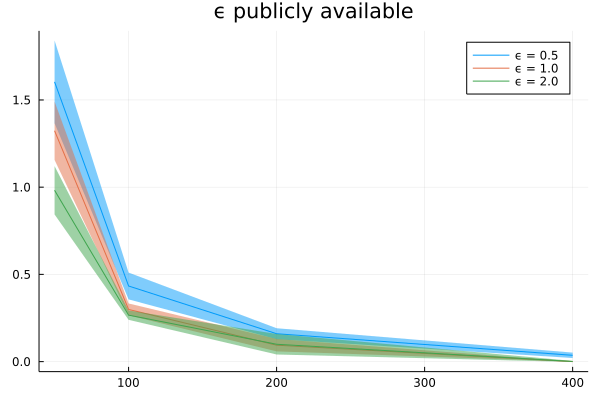

In [25]:
plt1 = plot(title="ϵ publicly available")
i=1; plot!(plt1, N, slice(we1, mean; dim=1, i=i), ribbon=slice(we1, std; dim=1, i=i), label="ϵ = $(ϵ[i])")
i=2; plot!(plt1, N, slice(we1, mean; dim=1, i=i), ribbon=slice(we1, std; dim=1, i=i), label="ϵ = $(ϵ[i])")
i=3; plot!(plt1, N, slice(we1, mean; dim=1, i=i), ribbon=slice(we1, std; dim=1, i=i), label="ϵ = $(ϵ[i])")
# i=4; plot!(plt1, N, slice(we1, mean; dim=1, i=i), ribbon=slice(we1, std; dim=1, i=i), label="ϵ = $(ϵ[i])")

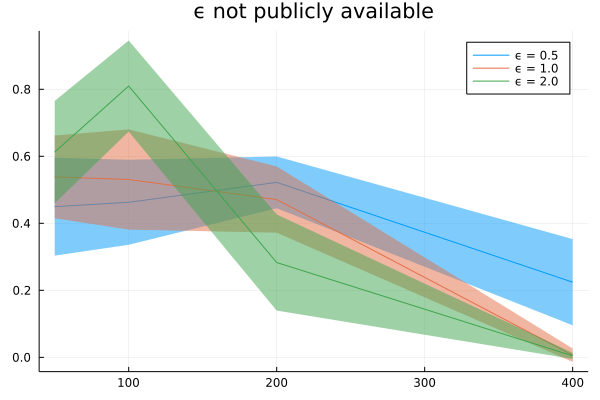

In [26]:
plt2 = plot(title="ϵ not publicly available")
i=1; plot!(plt2, N, slice(ne1, mean; dim=1, i=i), ribbon=slice(ne1, std; dim=1, i=i), label="ϵ = $(ϵ[i])")
i=2; plot!(plt2, N, slice(ne1, mean; dim=1, i=i), ribbon=slice(ne1, std; dim=1, i=i), label="ϵ = $(ϵ[i])")
i=3; plot!(plt2, N, slice(ne1, mean; dim=1, i=i), ribbon=slice(ne1, std; dim=1, i=i), label="ϵ = $(ϵ[i])")
# i=4; plot!(plt2, N, slice(ne1, mean; dim=1, i=i), ribbon=slice(ne1, std; dim=1, i=i), label="ϵ = $(ϵ[i])")

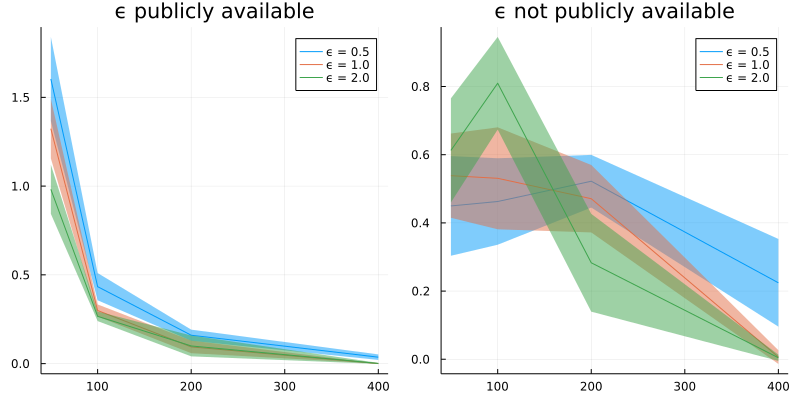

In [27]:
plot(plt1, plt2, size=(800, 400))